In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
display(HTML("<style>.output_result { max-width:90% !important; }</style>"))
display(HTML("<style>.prompt { display:none !important; }</style>"))

In [2]:
import os
import sys
import re
import datetime
import inspect
import bs4 as bs
import urllib.request
import pandas as pd
import matplotlib as mpl
import plotnine as pn

In [3]:
mlist = list(filter(lambda x: inspect.ismodule(x[1]), locals().items()))
vi = sys.version_info
print("Python: {0}.{1}.{2}".format(vi.major, vi.minor, vi.micro))
for name, mod in mlist:
    mname = None
    if name.startswith("__"):
        continue
    if hasattr(mod, "__version__"):
        if hasattr(mod, "__path__"):
            mname = os.path.split(mod.__path__[0])[1]
        if mname and mname != name:
            print("{0} as {1}: {2}".format(mname, name, mod.__version__))
        else:
            print("{0}: {1}".format(name, mod.__version__))            
    elif hasattr(mod, "__file__") and "site-packages" in mod.__file__:
        if mname and mname != name:
            print("{0} as {1}: No __version__ ".format(mname, name))
        else:
            print("{0}: No __version__ ".format(name))            
del mod
del name

Python: 3.9.0
re: 2.2.1
bs4 as bs: 4.9.3
pandas as pd: 1.1.3
matplotlib as mpl: 3.3.3
plotnine as pn: 0.7.1


In [4]:
url = "https://en.wikipedia.org/wiki/List_of_United_States_presidential_elections_by_popular_vote_margin"
source = urllib.request.urlopen(url).read()
soup = bs.BeautifulSoup(source,'lxml')
#<table class="wikitable sortable jquery-tablesorter" style="text-align:right;">
tables = soup.findAll('table', attrs={'class':'wikitable sortable'})

dfs ={}
table = tables[1]
table_rows = table.find_all('tr')
header_rows = []
for hrow in table_rows[:2]:
    ths = hrow.find_all('th')
    header_row = [(th.text.strip(), th.get('colspan')) for th in ths]
    header_rows.append(header_row)
l = []
for tr in table_rows[2:]:
    td = tr.find_all('td')
    row = [tr.text.strip() for tr in td]
    l.append(row)
df = pd.DataFrame(l, )
df.drop(labels=0, axis=1, inplace=True)

multi_hdr = [('Election', 'year'), ('Winner & party', 'Winner'), ('Winner & party', 'party'), 
             ('Electoral College', 'Votes'), ('Electoral College', 'Pct'), 
             ('Popular vote', 'Pct'), ('Popular vote', 'MarginPct'), 
             ('Popular vote', 'Votes'), ('Popular vote', 'Margin'), 
             ('Runner-up & party', 'Runner-up'), ('Runner-up & party', 'party'), 
             ('Turnout', 'Pct')]
df.columns = pd.MultiIndex.from_tuples(multi_hdr)
int_cols = [('Popular vote','Margin'), ('Popular vote','Votes')]
for ic in int_cols:
    df[ic] = df[ic].apply(lambda x: int(x.replace(',', '').replace("−", "-")))
df.loc[df[('Turnout', 'Pct')] == '-%',('Turnout', 'Pct')] = '65.4'
pct_cols = [('Electoral College', 'Pct'), ('Popular vote', 'Pct'),
            ('Popular vote', 'MarginPct'),('Turnout', 'Pct')]
for pc in pct_cols:
    try:
        df[pc] = df[pc].apply(lambda x: float(x.replace('%', '').replace("−", "-")))    
    except Exception as e:
        print(pc)
        raise Exception(e)
df.loc[df[('Election','year')] == '1788–89',('Election','year') ] = 1789
df.loc[df[('Election','year')] == '2020[Note 9]',('Election','year') ] = 2020
df[('Election','year')] = df[('Election','year')].apply(lambda x: int(x))        
print(df.head(2).to_string())
print()
print(df.tail(2).to_string())

  Election                Winner & party       Electoral College        Popular vote                         Runner-up & party               Turnout
      year                        Winner party             Votes    Pct          Pct MarginPct  Votes Margin         Runner-up         party     Pct
0     1789  Washington,George Washington  Ind.             69/69  100.0        100.0     100.0  43782  43782     ,No candidate  None[Note 1]    11.6
1     1792  Washington,George Washington  Ind.           132/132  100.0        100.0     100.0  28579  28579     ,No candidate  None[Note 1]     6.3

   Election      Winner & party       Electoral College        Popular vote                                     Runner-up & party       Turnout
       year              Winner party             Votes    Pct          Pct MarginPct     Votes   Margin                Runner-up party     Pct
57     2016  Trump,Donald Trump  Rep.           304/538  56.50        46.09     -2.09  62984828 -2868686  Clinton,H

<AxesSubplot:xlabel='(Election, year)'>

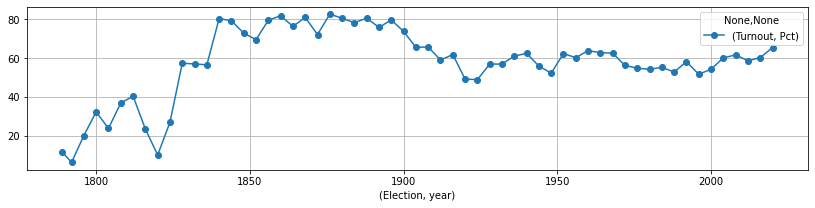

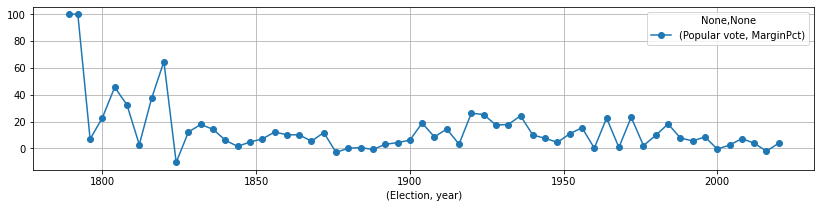

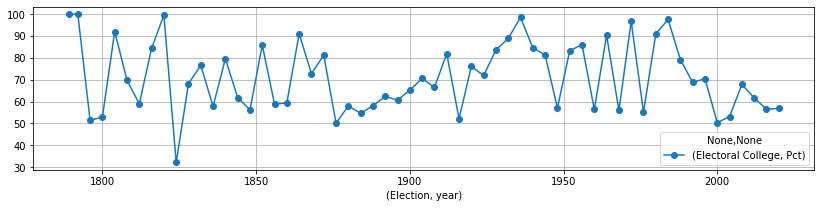

In [5]:

#df['date'] = df[[('Election','year')].apply(lamda x:datetime.date(x, 11,3))
figsize=(14,3)
df.plot(x=('Election','year'), y=('Turnout', 'Pct'), grid=True, figsize=figsize, marker='o')
df.plot(x=('Election','year'), y=('Popular vote', 'MarginPct'), grid=True,  figsize=figsize, marker='o')
df.plot(x=('Election','year'), y=('Electoral College', 'Pct'), grid=True,  figsize=figsize, marker='o')

In [6]:
import pathlib

import urllib.request
import bs4 as bs
import pandas as pd
from plotnine import ggplot
import matplotlib as mpl
import matplotlib.pyplot as plt

In [ ]:
temp_dir = "./temp"
if not os.path.isdir(temp_dir):
    os.mkdir(temp_dir)
prefs = {"download.default_directory" : os.path.abspath(temp_dir)}

options = webdriver.ChromeOptions()
options.add_experimental_option("prefs",prefs)
options.add_argument("download.default_directory="+os.path.abspath(temp_dir))

In [ ]:
df.shape

In [ ]:
chromedriver_path = os.path.join('../chromedriver_win32/chromedriver.exe')
driver = webdriver.Chrome(executable_path=chromedriver_path, options=options)
url = "https://en.wikipedia.org/wiki/List_of_United_States_presidential_elections_by_popular_vote_margin"
driver.get(url)

In [ ]:
newrows = []
for header_row in header_rows:
    newrow = []
    for el, dup in header_row:
        newrow.append(el)
        if dup:
            for i in range(int(dup)-1):
                newrow.append(el)
    print(newrow)
    newrows.append(newrow)
multirow = list(zip(newrows[0], newrows[1]))
print(multirow)

In [ ]:
table_id = self.driver.find_element(By.ID, 'data_configuration_feeds_ct_fields_body0')
rows = table_id.find_elements(By.TAG_NAME, "tr")

In [ ]:
for row in driver.find_elements_by_css_selector("wikitable"):
    cell = row.find_elements_by_tag_name("td")[1]
    print(cell.text)

In [ ]:
tbls = driver.find_elements_by_class_name("wikitable")
for tbl in tbls:
    df  = pd.read_html(tbl)
    print(df)
    rows = tbl.find_elements_by_tag_name("tr")
    for row in rows:
        td = row.find_elements_by_tag_name("td")
        dir(td)
